In [96]:
#%reset
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np
import eli5 
hfont = {'fontname':'Helvetica'}

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance


CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")


In [10]:
######## auROC by year #############
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
years = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

##### collect data for NN - dropped MSW and Midwest

model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )

X_train_nn = train_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train_nn = 1 - train_data['Susceptible']

X_train_nn, y_train_nn = oversample.fit_resample(X_train_nn,y_train_nn)

roc_auc_by_year_nn = []
for year in years:
     # test - vary by year dropped MSW and Midwest
     test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR']== year]
     X_test_nn = test_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
     y_test_nn = 1 - test_data['Susceptible']
     if year == 2019:
          oversample = RandomOverSampler(sampling_strategy = 0.7,random_state=42)

     X_test_nn, y_test_nn = oversample.fit_resample(X_test_nn,y_test_nn)

    # train model 
     model_fit_train = model_nn.fit(X_train_nn, y_train_nn)
     y_predict_test_nn = model_fit_train.predict(X_test_nn)

    #get ROC_AUC (implicit 0.5 threshold)
     roc_auc = metrics.roc_auc_score(y_test_nn, y_predict_test_nn)
     roc_auc_by_year_nn.append(roc_auc)



#### collect data for LR - drop west and southeast

model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')

#   train 
X_train_lr = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southwest',  'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train_lr = 1 - train_data['Susceptible']

roc_auc_by_year_lr = []
for year in years:
     # test - vary by year dropped MSW and Midwest
     test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR']== year]
     X_test_lr = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southwest',  'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
     y_test_lr = 1 - test_data['Susceptible']

    # train model 
     model_fit_train = model_lr.fit(X_train_lr, y_train_lr)
     y_predict_test_lr = model_fit_train.predict(X_test_lr)

    #get ROC_AUC (implicit 0.5 threshold)
     roc_auc = metrics.roc_auc_score(y_test_lr, y_predict_test_lr)
     roc_auc_by_year_lr.append(roc_auc)


#### collect data for RF - dropped  prev_region, southwest, northeast

model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)

feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Southeast',  'West', 'Midwest','PREV_CLINIC', 'DELTA_REGION']
#   train 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
X_train_rf = train_data[feature_names]
y_train_rf = 1 - train_data['Susceptible']
X_train_rf, y_train_rf = oversample.fit_resample(X_train_rf,y_train_rf)


roc_auc_by_year_rf = []
for year in years:
     # test - vary by year dropped MSW and Midwest
     test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR']== year]
     X_test_rf = test_data[feature_names]
     y_test_rf = 1 - test_data['Susceptible']

    # train model 
     model_fit_train = model_lr.fit(X_train_rf, y_train_rf)
     y_predict_test_rf = model_fit_train.predict(X_test_rf)

    #get ROC_AUC (implicit 0.5 threshold)
     roc_auc = metrics.roc_auc_score(y_test_rf, y_predict_test_rf)
     roc_auc_by_year_rf.append(roc_auc)




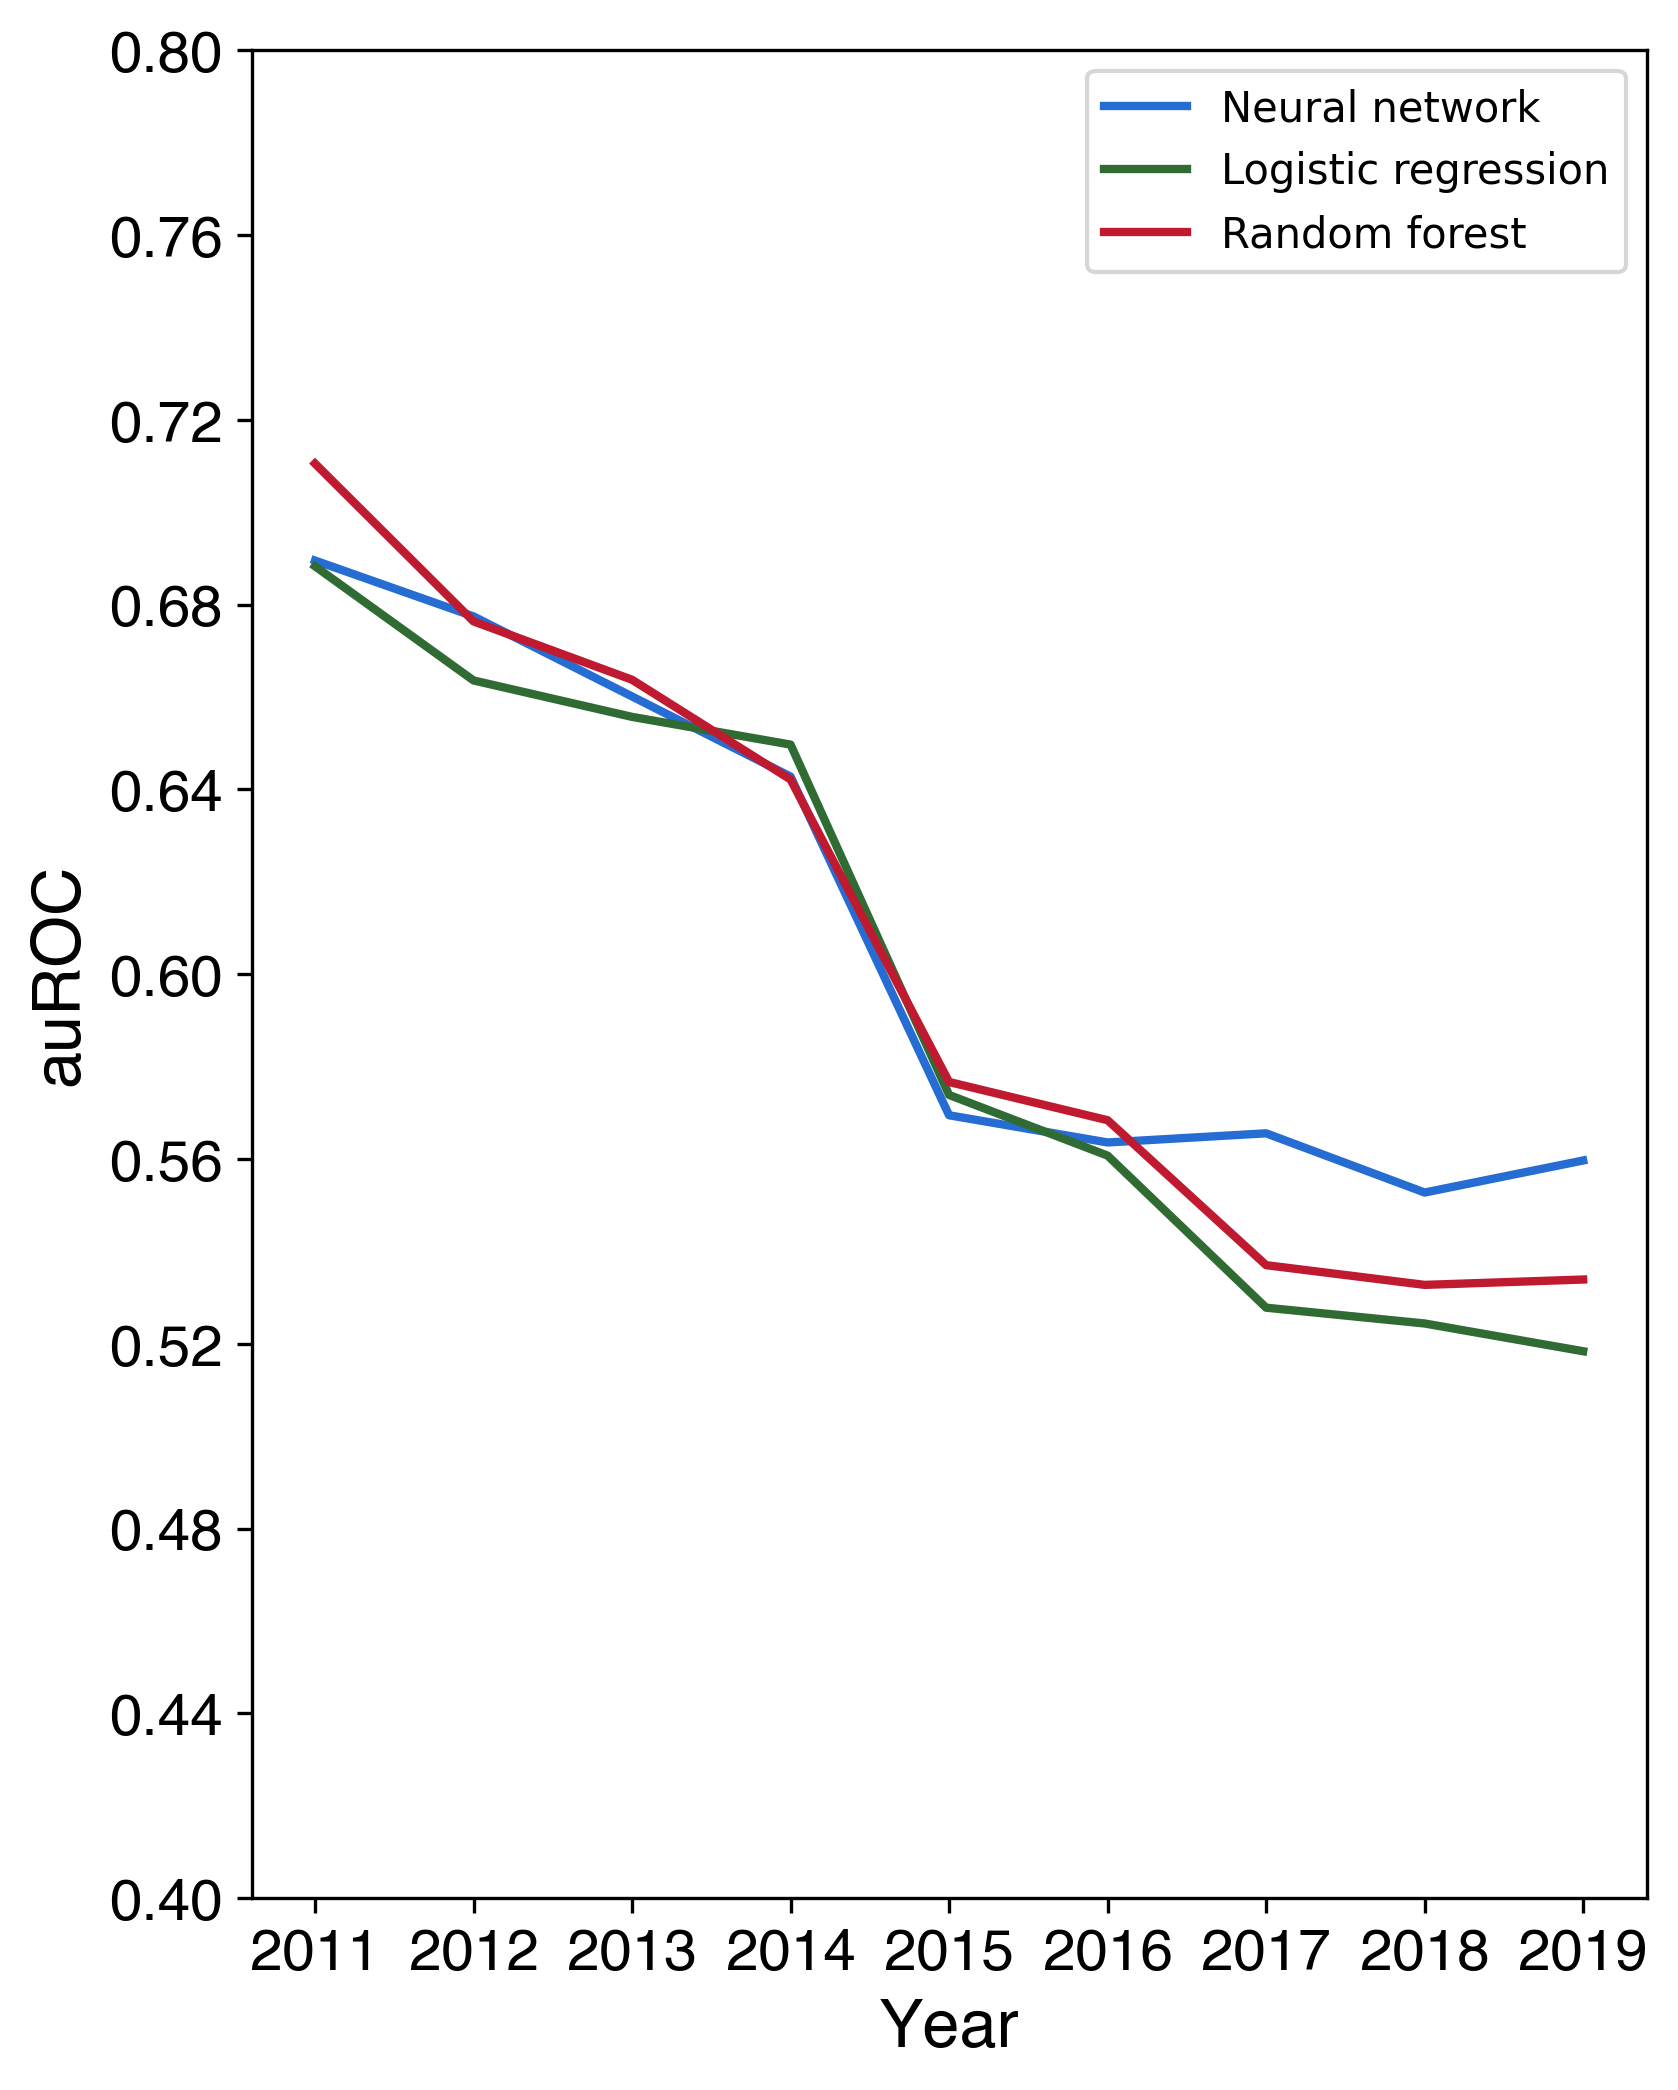

In [15]:
######### Efficiency of model different datasets - GRAPH 
years = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
plt.plot(years, roc_auc_by_year_nn, color = "#266DD3", linestyle = 'solid', linewidth = 2, label = "Neural network")
plt.plot(years, roc_auc_by_year_lr, color = "#306B34", linestyle = 'solid', linewidth = 2, label = "Logistic regression")
plt.plot(years, roc_auc_by_year_rf, color = "#BF1A2F", linestyle = 'solid', linewidth = 2, label = "Random forest")

plt.xlabel("Year", fontsize=16,**hfont)
plt.ylabel("auROC", fontsize=16,**hfont)
plt.xticks(years, fontsize=14,**hfont)
plt.yticks(np.linspace(0.4,0.8,11), fontsize=14,**hfont)
plt.ylim([0.4,0.8])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [6,8]
plt.legend()
plt.savefig('Graphs/auROC_single_test_years_all_workflow_paper_all_models.png')

In [9]:
print(roc_auc_by_year_lr)

[0.759304650587546, 0.759304650587546, 0.759304650587546, 0.759304650587546, 0.759304650587546, 0.759304650587546, 0.759304650587546, 0.759304650587546, 0.759304650587546]


In [97]:
#%reset
### Bar charts of feature importance by model - NB USE ALL FEATURES 


train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]

feature_names_all =  ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','Prev. Region', 'Prev. Clinic','Change']
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)

## Neural network  
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )

X_train_nn = train_data[feature_names_all]
y_train_nn = 1 - train_data['Susceptible']

X_train_nn, y_train_nn = oversample.fit_resample(X_train_nn,y_train_nn)

X_test_nn = test_data[feature_names_all]
y_test_nn = 1 - test_data['Susceptible']

X_test_nn, y_test_nn = oversample.fit_resample(X_test_nn,y_test_nn)

model_fit_nn = model_nn.fit(X_train_nn, y_train_nn)
PI_nn = permutation_importance(model_fit_nn, X_test_nn, y_test_nn, n_repeats = 10, random_state = 42)
#feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']

## Logistic regression
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')
 
X_train_lr = train_data[feature_names_all]
y_train_lr = 1 - train_data['Susceptible']
X_test_lr = test_data[feature_names_all]
y_test_lr = 1 - test_data['Susceptible']

model_fit_lr = model_lr.fit(X_train_lr, y_train_lr)
PI_lr = permutation_importance(model_fit_lr, X_test_lr, y_test_lr, n_repeats = 10, random_state = 42)

## Random forest 
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)

X_train_rf = train_data[feature_names_all]
y_train_rf = 1 - train_data['Susceptible']
X_train_rf, y_train_rf = oversample.fit_resample(X_train_rf,y_train_rf)
model_fit_rf = model_rf.fit(X_train_rf, y_train_rf)

X_test_rf = test_data[feature_names_all]
y_test_rf = 1 - test_data['Susceptible']

X_test_rf, y_test_rf = oversample.fit_resample(X_test_rf,y_test_rf)

PI_rf = permutation_importance(model_fit_rf, X_test_rf, y_test_rf, n_repeats = 10, random_state = 42)





<BarContainer object of 12 artists>

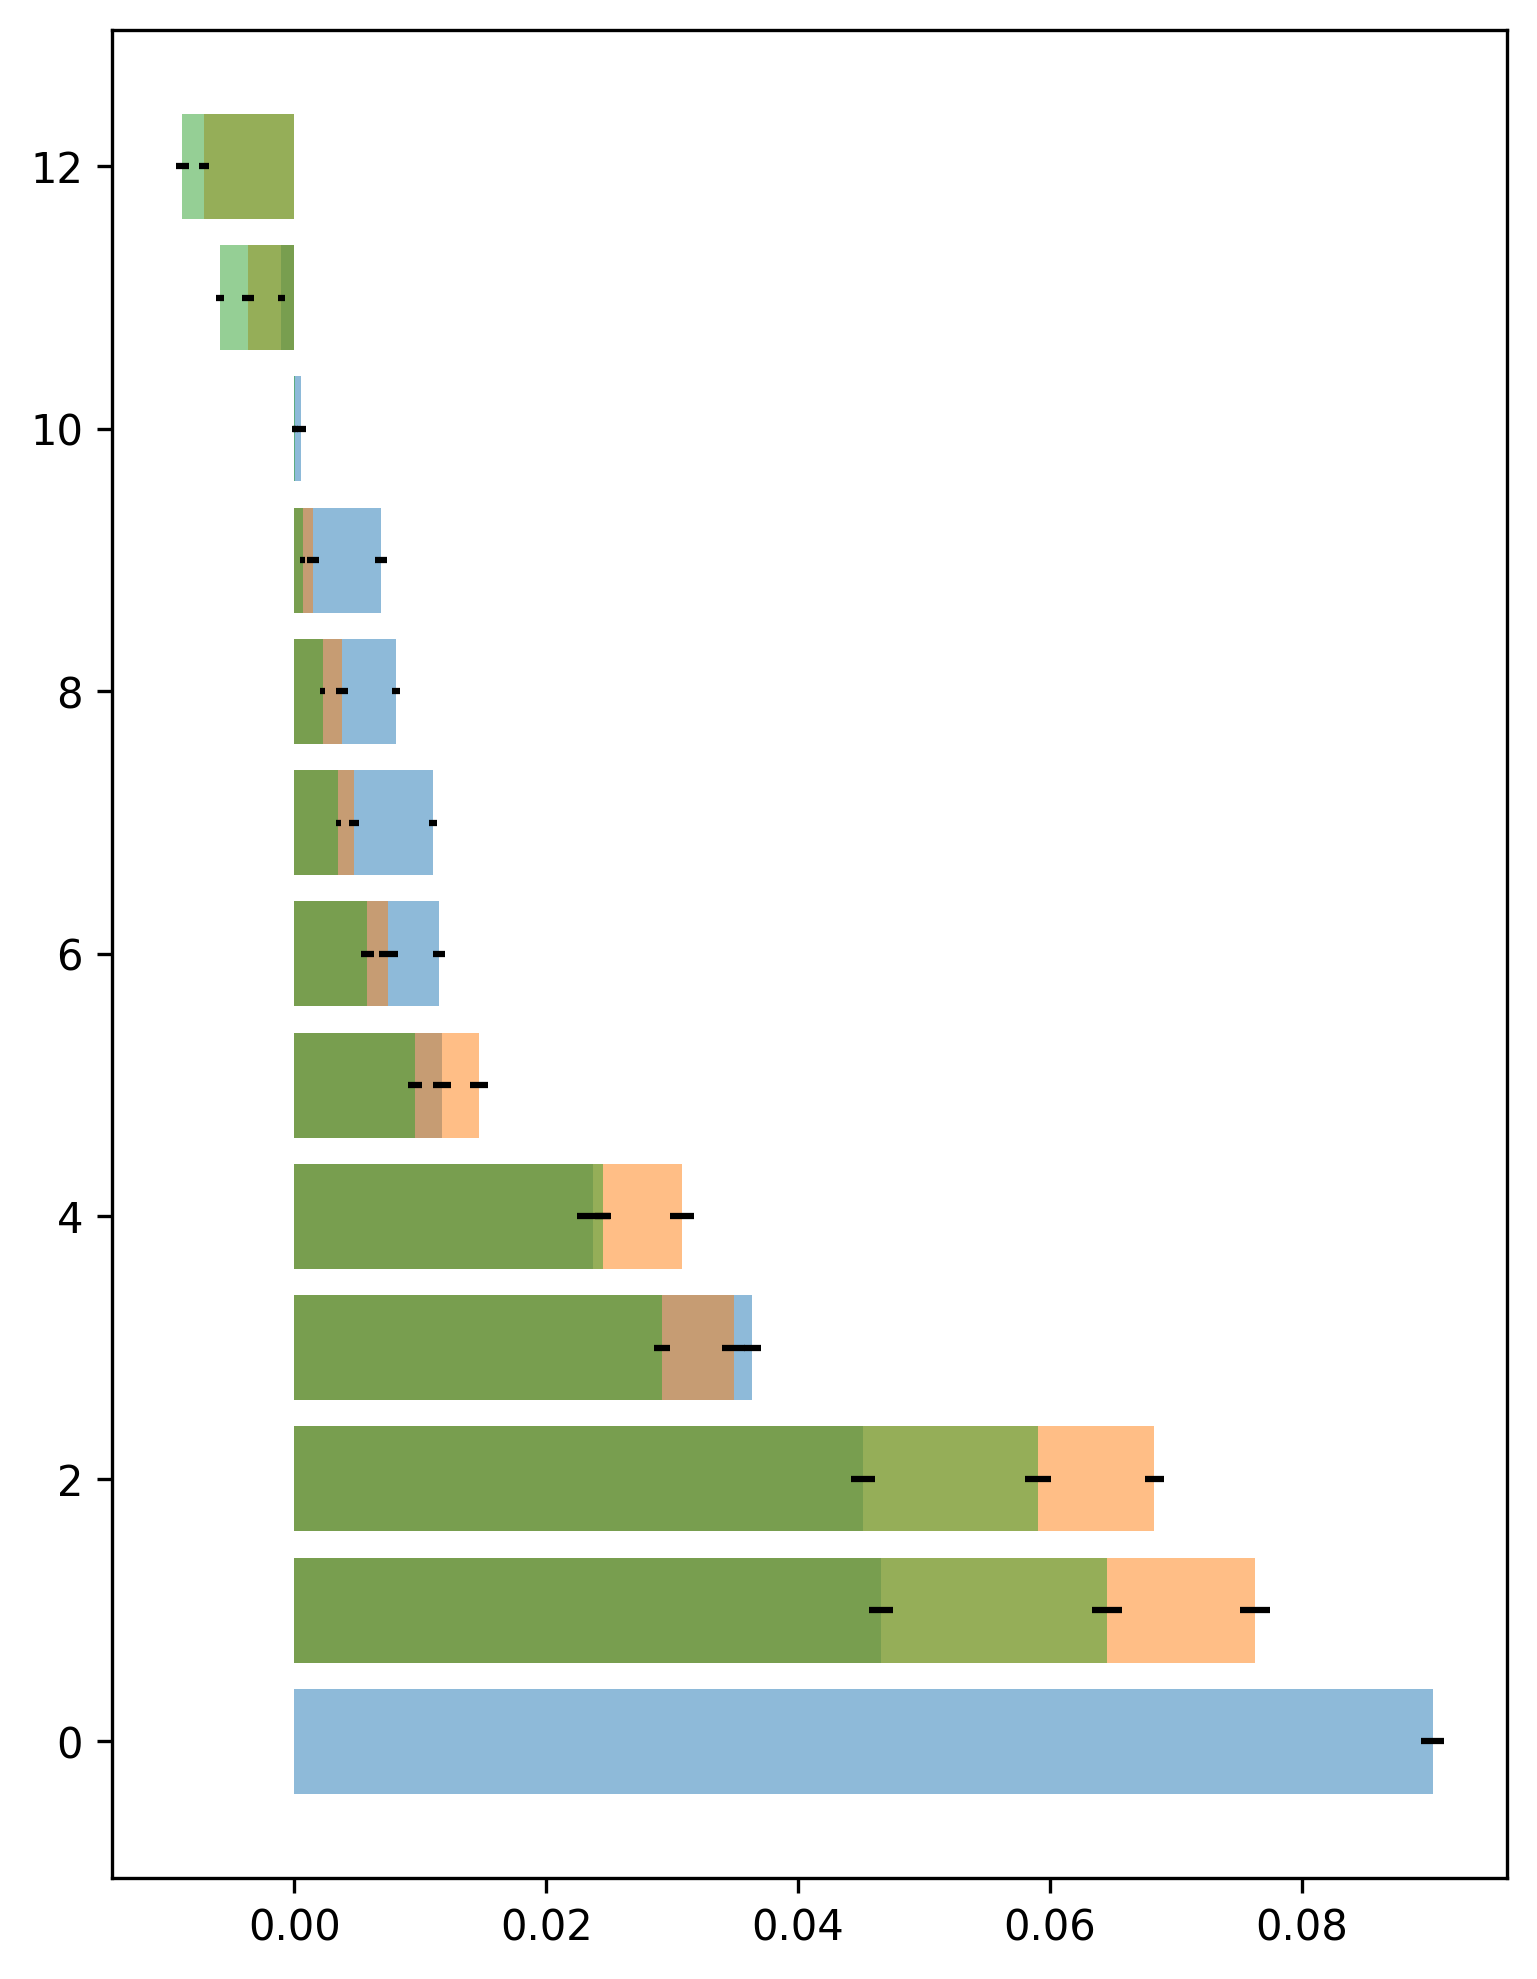

In [71]:
### graph feature engineering results for nn
feature_names = np.array(feature_names)
fig, ax = plt.subplots()


### graph feature engineering results for nn
feature_names_by_importance_nn = feature_names[PI_nn.importances_mean.argsort()[::-1]]
mean_importance_by_importance_nn = PI_nn.importances_mean[PI_nn.importances_mean.argsort()[::-1]]
std_importance_by_importance_nn = PI_nn.importances_std[PI_nn.importances_mean.argsort()[::-1]]

ax.barh(y = range(mean_importance_by_importance_nn.size), width =mean_importance_by_importance_nn,
 xerr= std_importance_by_importance_nn, alpha = 0.5)#c8b6ff") # xmin = min(feature_names_by_importance), xmax = max(feature_names_by_importance))
#ax.yticks(range(feature_names_by_importance_nn.size), feature_names_by_importance_nn)


### graph feature engineering results for lr
offset =  range(mean_importance_by_importance_nn.size)
width_add = np.min(np.diff(offset))/1.
width_add = 0
#width_add = 1
feature_names_by_importance_lr= feature_names[PI_lr.importances_mean.argsort()[::-1]]
mean_importance_by_importance_lr = PI_lr.importances_mean[PI_lr.importances_mean.argsort()[::-1]]
std_importance_by_importance_lr = PI_lr.importances_std[PI_lr.importances_mean.argsort()[::-1]]
#[*range(mean_importance_by_importance_lr.size), width_add]
ax.barh(y = np.arange(1,mean_importance_by_importance_lr.size + 1,1) + width_add, width =mean_importance_by_importance_lr,
 xerr= std_importance_by_importance_lr, alpha = 0.5)#c8b6ff") # xmin = min(feature_names_by_importance), xmax = max(feature_names_by_importance))
#ax.yticks(range(feature_names_by_importance_lr.size), feature_names_by_importance_lr)

#plt.savefig('Graphs/Features_by_importance_post_hyperparameter_logistic_regression.png')

### graph feature engineering results for rf
feature_names_by_importance_rf= feature_names[PI_rf.importances_mean.argsort()[::-1]]
mean_importance_by_importance_rf = PI_rf.importances_mean[PI_rf.importances_mean.argsort()[::-1]]
std_importance_by_importance_rf = PI_rf.importances_std[PI_rf.importances_mean.argsort()[::-1]]

ax.barh(y = np.arange(1,mean_importance_by_importance_rf.size + 1,1)+ 3*width_add, width =mean_importance_by_importance_rf,
 xerr= std_importance_by_importance_rf, alpha = 0.5)#c8b6ff") # xmin = min(feature_names_by_importance), xmax = max(feature_names_by_importance))
#ax.yticks(range(feature_names_by_importance_rf.size), feature_names_by_importance_rf)



In [63]:
print(np.arange(1,mean_importance_by_importance_lr.size,1))

[ 1  2  3  4  5  6  7  8  9 10 11]


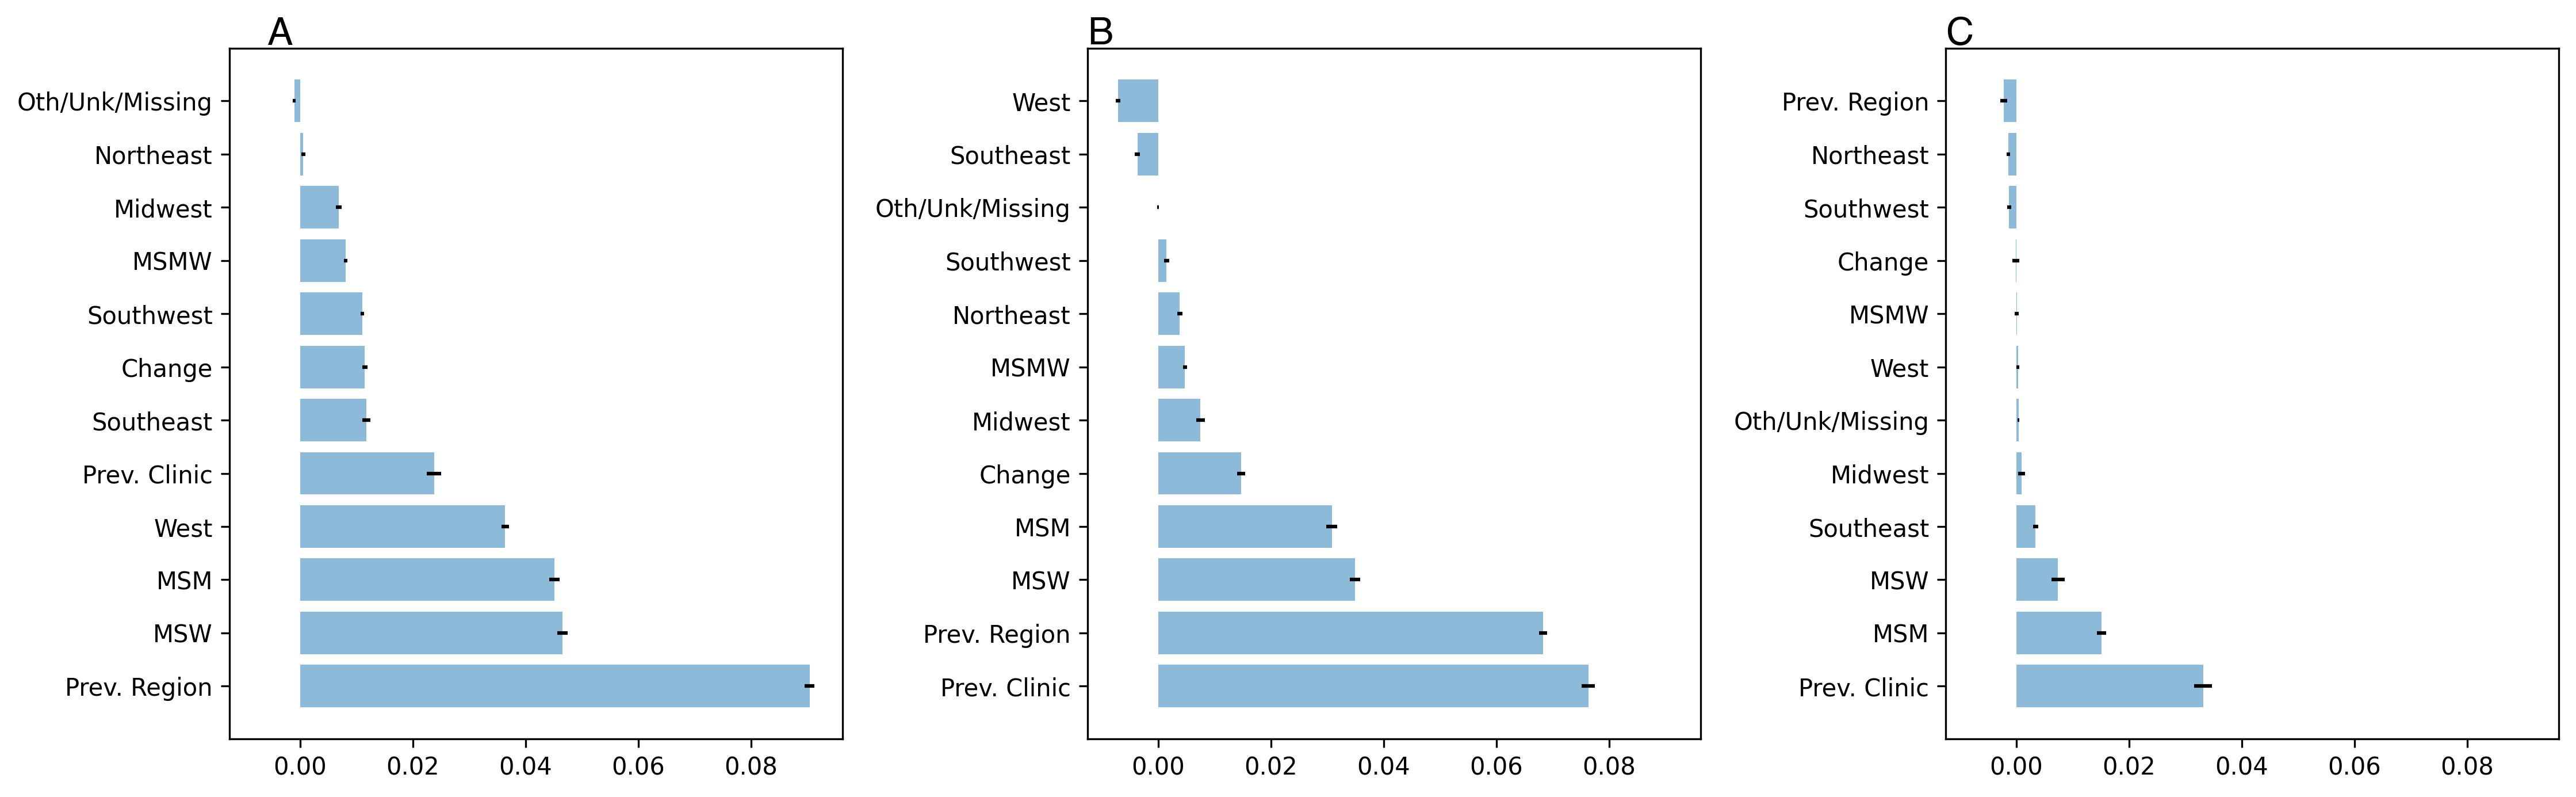

In [111]:
### or try three separate plots 
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','Prev. Region', 'Prev. Clinic','Change']

feature_names = np.array(feature_names)

fig, axs = plt.subplots(1,3, figsize=(20, 5), facecolor='w', edgecolor='k', sharex='all',  sharey = False)
fig.subplots_adjust(left=0.225, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.2)



### graph feature engineering results for nn
feature_names_by_importance_nn = feature_names[PI_nn.importances_mean.argsort()[::-1]]
mean_importance_by_importance_nn = PI_nn.importances_mean[PI_nn.importances_mean.argsort()[::-1]]
std_importance_by_importance_nn = PI_nn.importances_std[PI_nn.importances_mean.argsort()[::-1]]

axs[0].barh(y = range(mean_importance_by_importance_nn.size), width =mean_importance_by_importance_nn,
 xerr= std_importance_by_importance_nn, alpha = 0.5)#c8b6ff") # xmin = min(feature_names_by_importance), xmax = max(feature_names_by_importance))
axs[0].set_yticks(range(feature_names_by_importance_nn.size))

axs[0].set_yticklabels( feature_names_by_importance_nn)
axs[0].text(axs[0].get_xlim()[0] , axs[0].get_ylim()[1] + 0.07, 'A', fontsize = 16, **hfont)


### graph feature engineering results for lr

feature_names_by_importance_lr= feature_names[PI_lr.importances_mean.argsort()[::-1]]
mean_importance_by_importance_lr = PI_lr.importances_mean[PI_lr.importances_mean.argsort()[::-1]]
std_importance_by_importance_lr = PI_lr.importances_std[PI_lr.importances_mean.argsort()[::-1]]
#[*range(mean_importance_by_importance_lr.size), width_add]
axs[1].barh(y = np.arange(1,mean_importance_by_importance_lr.size + 1,1), width =mean_importance_by_importance_lr,
 xerr= std_importance_by_importance_lr, alpha = 0.5)#c8b6ff") # xmin = min(feature_names_by_importance), xmax = max(feature_names_by_importance))
axs[1].set_yticks(np.arange(1,mean_importance_by_importance_lr.size + 1,1))
axs[1].set_yticklabels( feature_names_by_importance_lr)
axs[1].text(axs[1].get_xlim()[0] , axs[1].get_ylim()[1] + 0.07, 'B', fontsize = 16, **hfont)

### graph feature engineering results for rf
feature_names_by_importance_rf= feature_names[PI_rf.importances_mean.argsort()[::-1]]
mean_importance_by_importance_rf = PI_rf.importances_mean[PI_rf.importances_mean.argsort()[::-1]]
std_importance_by_importance_rf = PI_rf.importances_std[PI_rf.importances_mean.argsort()[::-1]]

axs[2].barh(y = np.arange(1,mean_importance_by_importance_rf.size + 1,1), width =mean_importance_by_importance_rf,
 xerr= std_importance_by_importance_rf, alpha = 0.5)#c8b6ff") # xmin = min(feature_names_by_importance), xmax = max(feature_names_by_importance))
axs[2].set_yticks(np.arange(1,mean_importance_by_importance_lr.size + 1,1))
axs[2].set_yticklabels( feature_names_by_importance_rf)
axs[2].text(axs[2].get_xlim()[0] , axs[2].get_ylim()[1] + 0.07, 'C', fontsize = 16, **hfont)

#plt.savefig('Graphs/Features_by_importance_post_hyperparameter_all_models.png')


<class 'range'>
<class 'numpy.float64'>


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_89868/2824575994.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.axes.set_xticklabels(names)


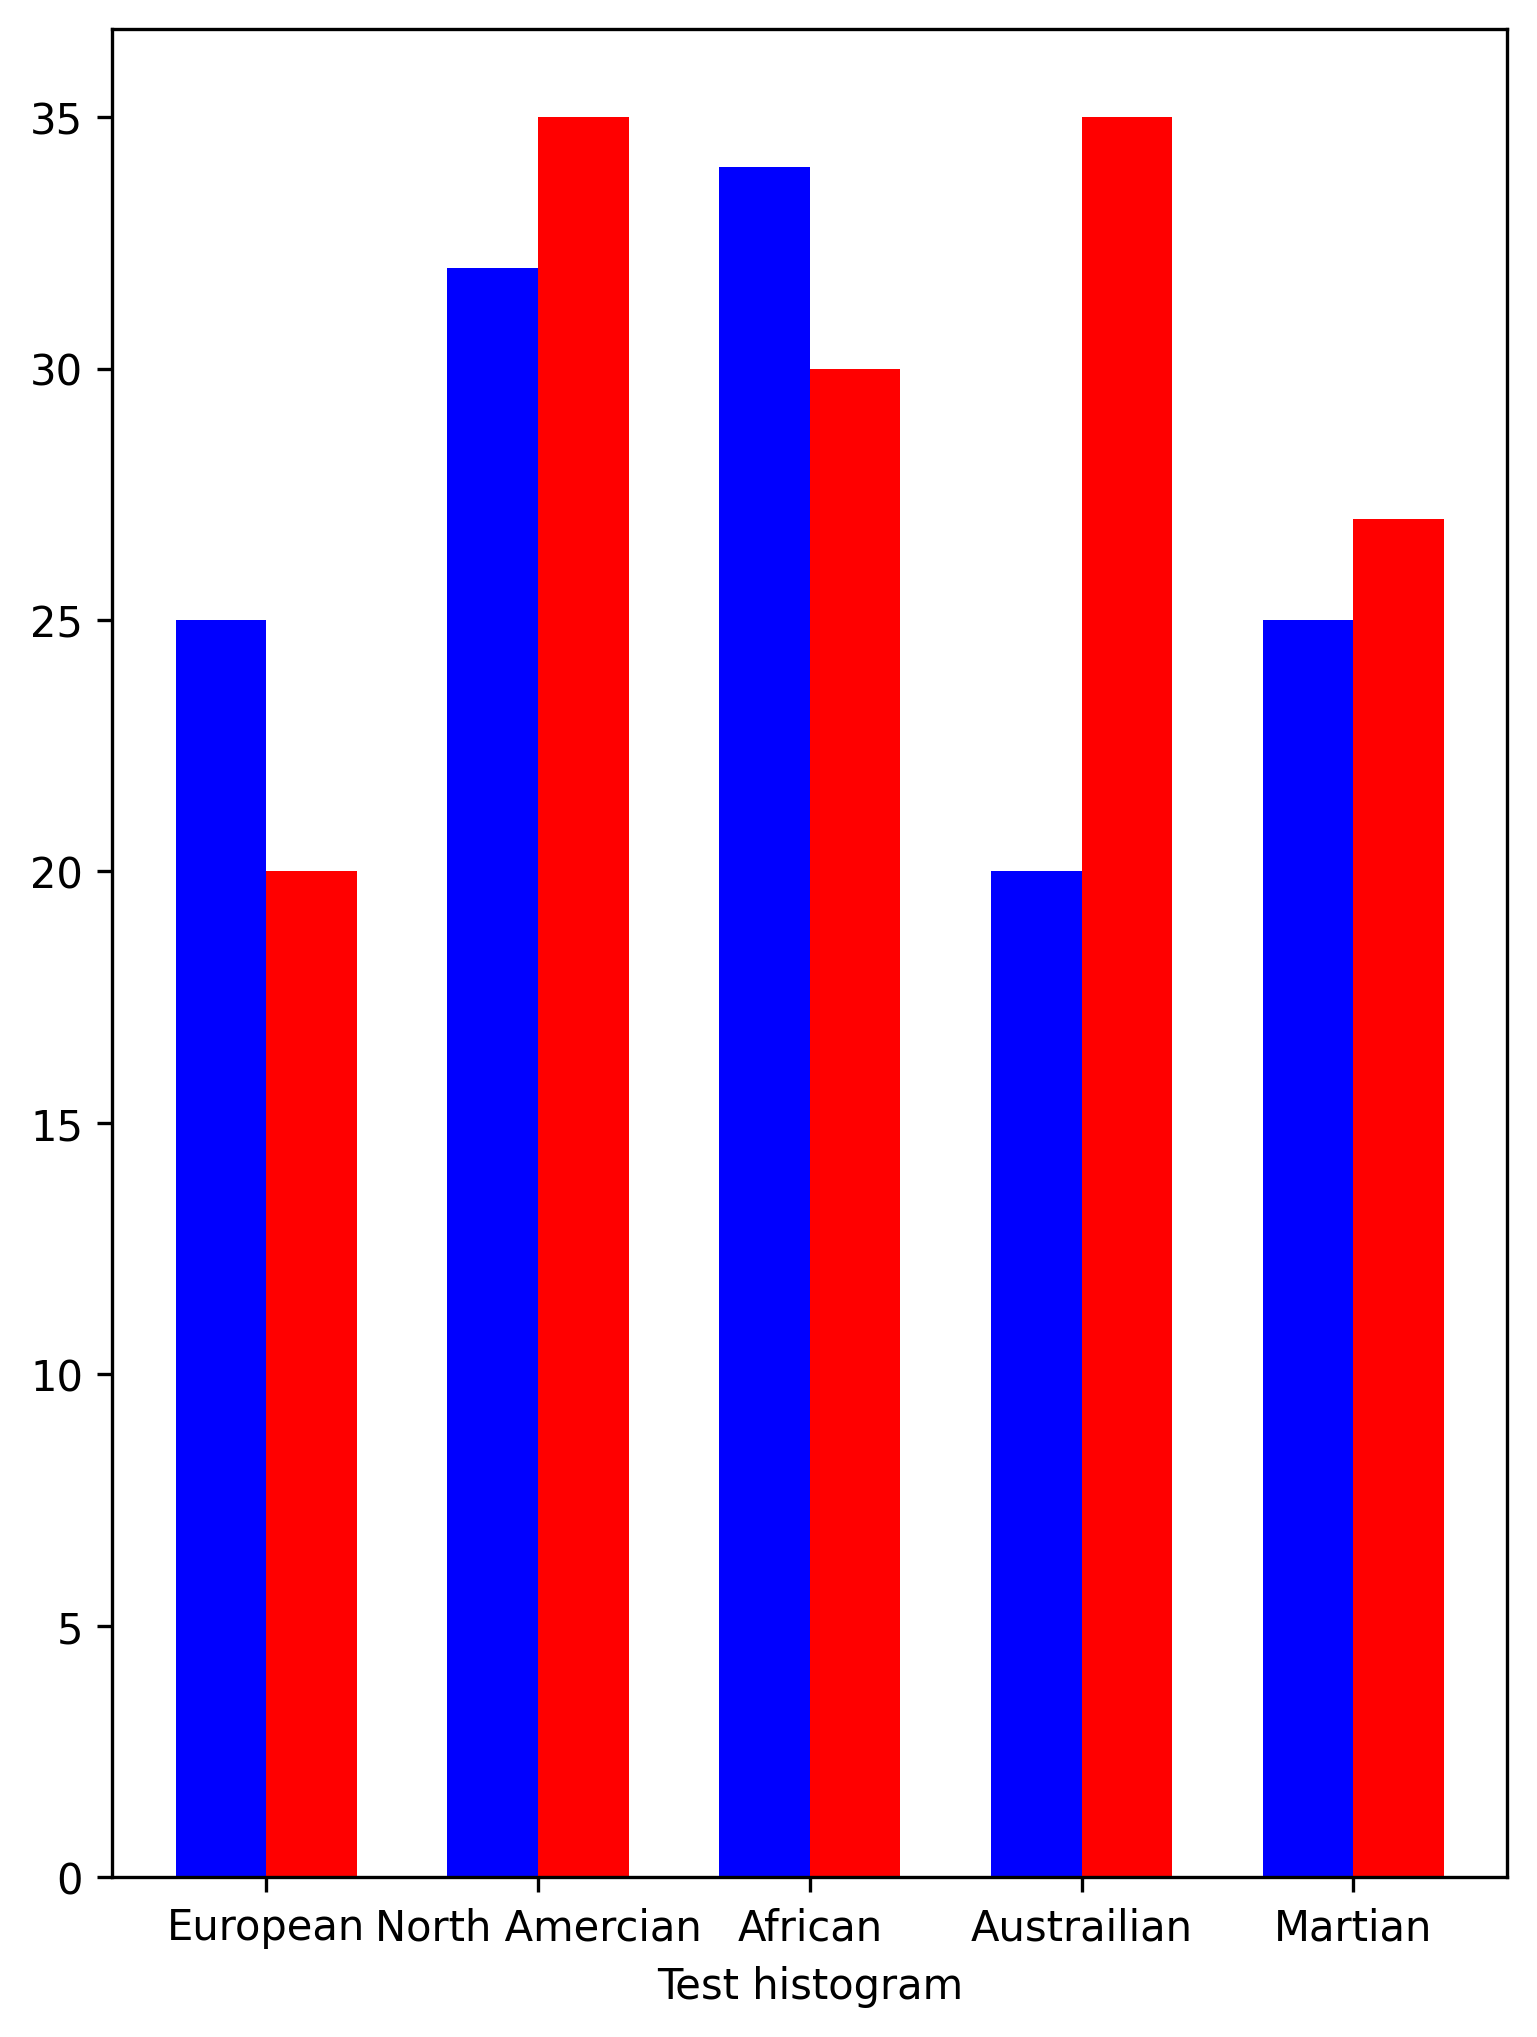

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# The data
womenMeans = (25, 32, 34, 20, 25)
menMeans = (20, 35, 30, 35, 27)
indices = range(len(womenMeans))
print(type(indices))
names = ['Asian','European','North Amercian','African','Austrailian','Martian']
# Calculate optimal width
width = np.min(np.diff(indices))/3.
print(type(width))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(indices-width/2.,womenMeans,width,color='b',label='-Ymin')
ax.bar(indices+width/2.,menMeans,width,color='r',label='Ymax')
#tiks = ax.get_xticks().tolist()
ax.axes.set_xticklabels(names)
ax.set_xlabel('Test histogram')
plt.show()